In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import logging
from tqdm import TqdmWarning
warnings.filterwarnings(module="tqdm.auto", action="ignore", category=TqdmWarning)
warnings.filterwarnings(module="sklearn.feature_extraction.text", action="ignore", category=UserWarning)

from rfc.storage.tfidf import TfidfStorage
from rfc.scrap import scrap
from rfc.index.base import UrlQuery, DocQuery, TextQuery, NameQuery
from rfc.index.tfidf import TfidfIndex
from rfc.index.backends.spacy import SpaCyTfidfVectorizer, download_if_not_exists
from rfc.utils.logging import Logger

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE

# Request For Comments (RFC)

Authors:
* Vasyl Korzavatykh 158669
* Andrii Chmutov 154974

A **Request for Comments** (RFC) is a publication in a series from the principal technical development and standards-setting bodies for the Internet, most prominently the **Internet Engineering Task Force** (IETF). An RFC is authored by individuals or groups of engineers and computer scientists in the form of a memorandum describing methods, behaviors, research, or innovations applicable to the working of the Internet and Internet-connected systems. It is submitted either for peer review or to convey new concepts, information, or, occasionally, engineering humor.

Our bespoke implementation of search system aims to simplify the process of navigating the website and kick-off the user experience to the next level.

## Configuration

Configure the Project Report with the following parameters:

In [98]:
load_docs = True
load_index = True

db = "huge.sqlite"
loglevel = "INFO"
vectorizer_path = "huge.pkl"
nlp_model = "en_core_web_sm"
limit: int = 5
starting_nodes = [
    "https://datatracker.ietf.org/doc/html/rfc791",
]
decay = lambda x: 1.2 ** (-5-x)

# Download the model if needed
download_if_not_exists(nlp_model)

# Logging verbosity
Logger.setLevel(loglevel)

## Scraping

In our implementation, crawling is performed manually using **following external external links** that match a predefined pattern in **DFS-like** fashion. We opted not to use external library since the results made with our cralwer were satisfactory.

However, we did use dependency for scraping - `inscriptis` performs HTML processing pretty well.

Note: `TfidfStorage` is wrapper for `SQLite` database, that stores both documents and indexer. 

In [3]:
storage = TfidfStorage(db, vectorizer_path)

if not load_docs:
    docs = scrap(starting_nodes, limit, storage=storage, mode="overwrite")
else:
    docs = storage.fetchall()

## Indexing

In this section, we create **TF-IDF index** based on scraped data.

It is worth noting:
* we use `en_core_web_sm` for tokenization and **lemmatization**. although you can define bigger model if you want). Punctuation and stopwords defined by `spaCy` are skipped.
* you may use **another model** (`spaCy` models are installed automatically)
* create a **wrapper** for `TfidfVectorizer` (inheriting from `BaseTfidfVectorizer` from this package) (the model should also be picklabe) that would incorporate **custom backend**


In [4]:
if not load_index:
    tfidf_vectorizer = SpaCyTfidfVectorizer(spacy_model_name=nlp_model)

    index = TfidfIndex.from_docs(docs, tfidf_vectorizer)
    storage.save(index)
else:
    index = storage.load()

root(INFO) - Loading the index (tfidf.py:44)
root(INFO) - Reading tfidf (tfidf.py:167)
root(INFO) - Reading bow (tfidf.py:167)
root(INFO) - Reading idf (tfidf.py:188)


## Scoring

We decided **not** to use some specific tools, like [Qdrant](https://qdrant.tech/) since it might be forbidden. Therefore, we use **Cosine Similarity** for **TF-IDF** vectors as a backbone metric to measure distances betweem vectors.

### Single document / string

In this case, we get a single vector from a document, similarity to which we compute for all other documents in the database. 

In [5]:
temp_docs = index.query("ICMP")

list(map(str, temp_docs))[:5]

root(INFO) - Performing lemmatization (tfidf.py:118)
root(INFO) - Transforming TF-IDF (tfidf.py:121)


['0.573 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc4884", name="RFC 4884 - Extended ICMP to Support Multi-Part Messages", text=...)',
 '0.474 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc5927", name="RFC 5927 - ICMP Attacks against TCP", text=...)',
 '0.327 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc4443", name="RFC 4443 - Internet Control Message Protocol (ICMPv6) for the Internet Protocol Version 6 (IPv6) Specification", text=...)',
 '0.308 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc1788", name="RFC 1788 - ICMP Domain Name Messages", text=...)',
 '0.302 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc6791", name="RFC 6791 - Stateless Source Address Mapping for ICMPv6 Packets", text=...)']

We can see that ICMP article pops up as the most relevant, which is a desired behavior.

### Multiple documents

When querying by history, we perform the same operation as we did in case for a single document, but then we **aggregate** results by **weighted average**, with weight defined by the decay function.


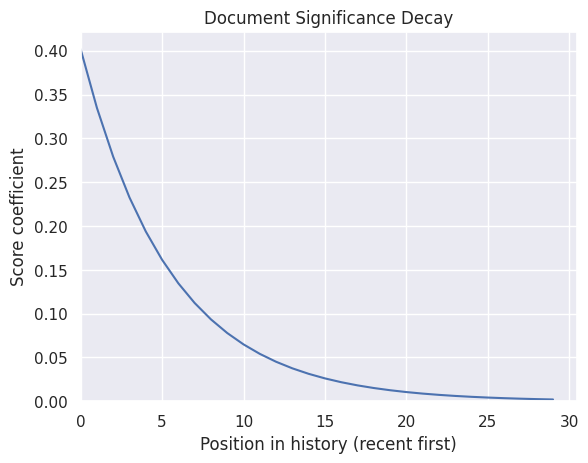

In [99]:
# History with 30 documents
x = np.arange(0, 30)
y = decay(x)

plt.plot(x, y)
plt.title("Document Significance Decay")
plt.xlabel("Position in history (recent first)")
plt.ylabel("Score coefficient")
plt.xlim(0)
plt.ylim(0);

In this project, we use exponential decay.

## Interesting statistics

#### General stats

In [7]:
print("Number of documents", len(docs))
print("Vocabulary size", len(index.tfidf.columns))
print("Average number of tokens", (index.bow).sum(1).mean())
print("Average number of words", sum([len(doc.text.split()) for doc in docs]) / len(docs))

Number of documents 1000
Vocabulary size 75321
Average number of tokens 4953.793
Average number of words 8388.342


#### Most frequent words

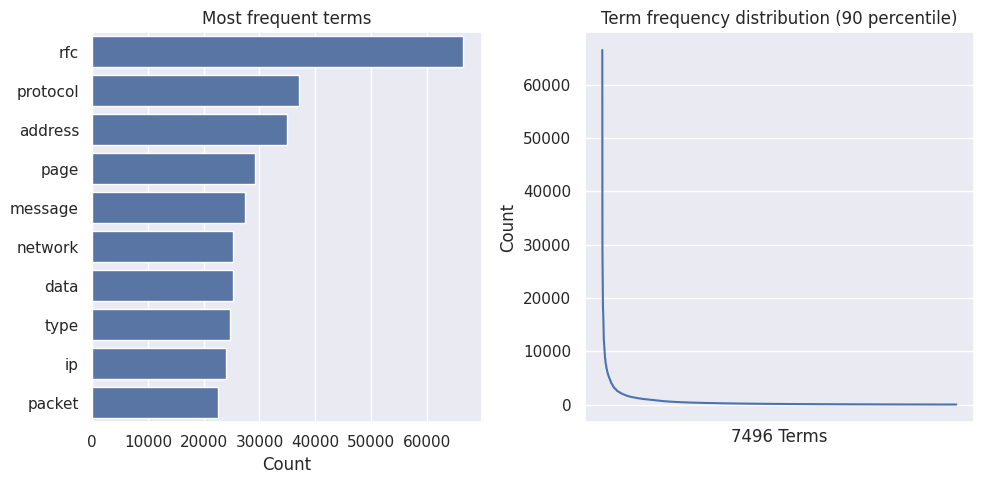

In [8]:
limit_output = 10

_, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].set_title("Most frequent terms")
axes[0].set_xlabel("Count")
sns.barplot(index.bow.sum().sort_values()[::-1][:limit_output], orient="h", ax=axes[0]);

term_frequencies = index.bow.sum().sort_values(ascending=False)
percentile_n = 90
percentile = np.percentile(term_frequencies, percentile_n)
term_frequencies = term_frequencies[term_frequencies > percentile]

axes[1].set_title(f"Term frequency distribution ({percentile_n} percentile)")
axes[1].set_xlabel(f"{len(term_frequencies)} Terms")
axes[1].set_ylabel("Count")
axes[1].set_xticks([])

sns.lineplot(term_frequencies, ax=axes[1])
plt.tight_layout()

#### Most important words

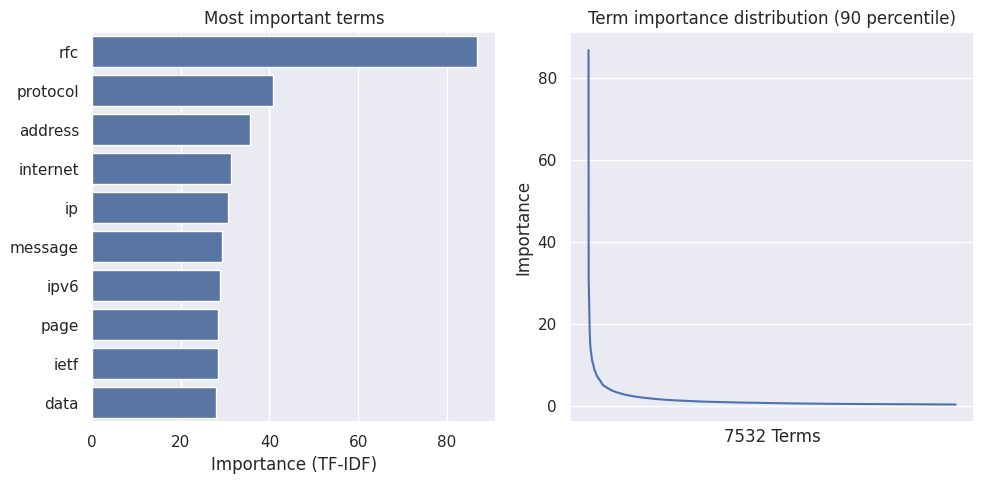

In [9]:
limit_output = 10

_, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].set_title("Most important terms")
axes[0].set_xlabel("Importance (TF-IDF)")
sns.barplot(index.tfidf.sum().sort_values()[::-1][:limit_output], orient="h", ax=axes[0]);

term_frequencies = index.tfidf.sum().sort_values(ascending=False)
percentile_n = 90
percentile = np.percentile(term_frequencies, percentile_n)
term_frequencies = term_frequencies[term_frequencies > percentile]

axes[1].set_title(f"Term importance distribution ({percentile_n} percentile)")
axes[1].set_xlabel(f"{len(term_frequencies)} Terms")
axes[1].set_ylabel("Importance")
axes[1].set_xticks([])

sns.lineplot(term_frequencies, ax=axes[1])
plt.tight_layout()

Even though the data is aggregated and the IDF is now effectively vanished (hence no drammatic changes compared to regular BOW), still the logarithm seems to smooth the changes.

TF-IDF distribution, at least for the most important terms, is more even compared to frequency.

#### Document similarity

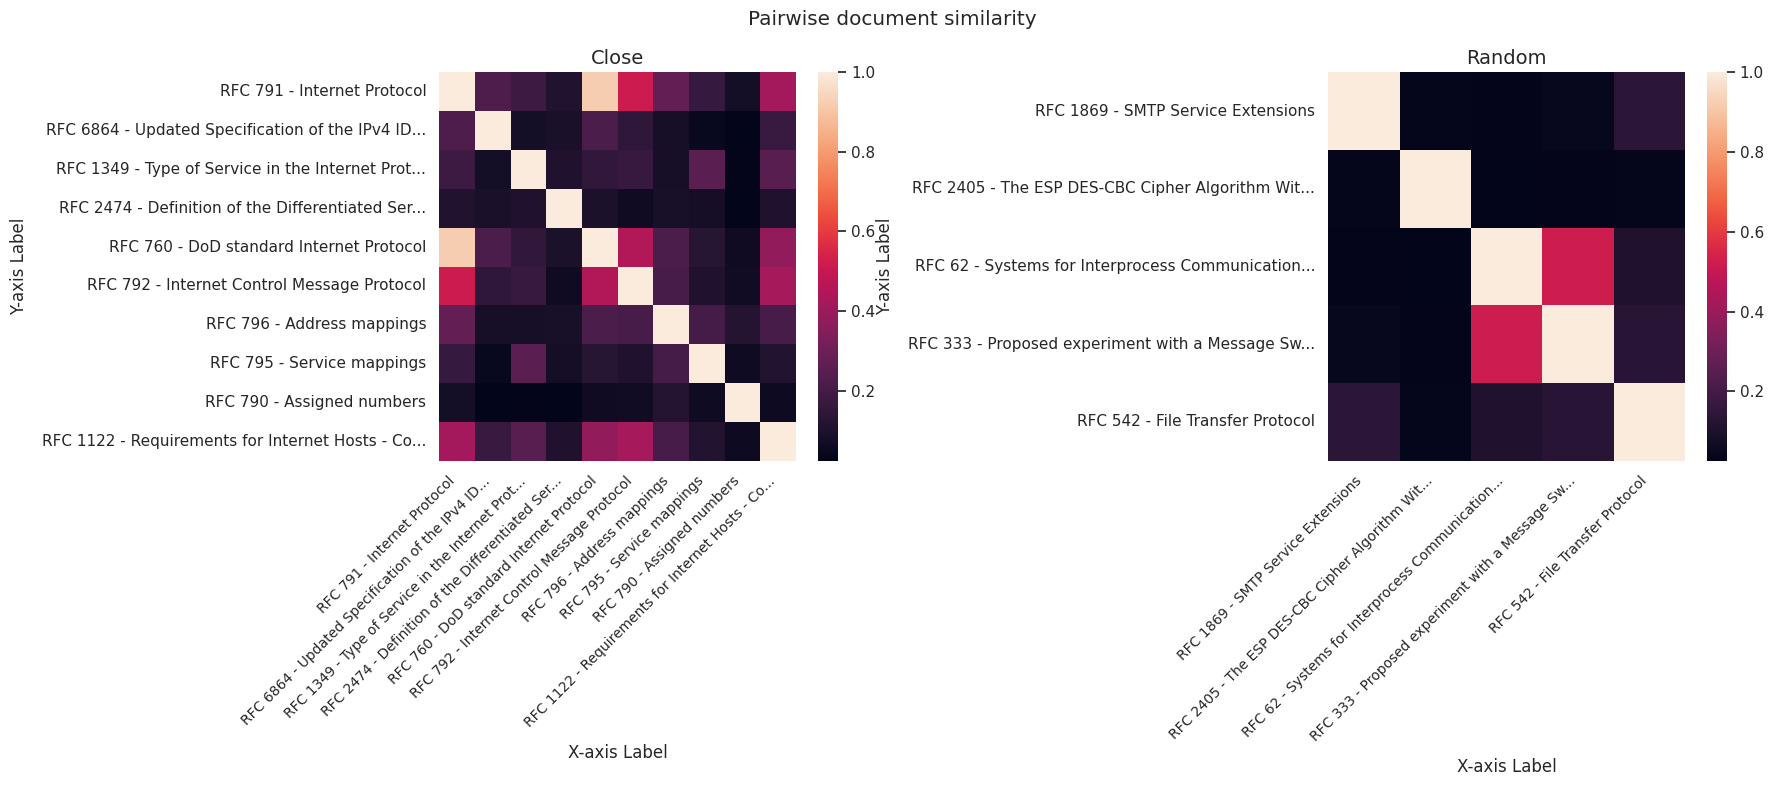

In [52]:
limit_output = 10

# Get random indices
np.random.seed(21)
random_indices = np.arange(len(docs))
np.random.shuffle(random_indices)
random_indices = random_indices[:limit_output]

selected_indices = [
    (np.arange(limit_output), "Close"),
    (random_indices, "Random"),
]

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle("Pairwise document similarity")

for i, (indices, label) in enumerate(selected_indices):
    selected_docs = [docs[i] for i in indices]
    names = []
    scores = []
    for doc in selected_docs:
        if len(doc.name) > 50:
            name = doc.name[:47] + "..."
            names.append(name)
        else:
            names.append(doc.name)
        
        ranked = index.query_docs([DocQuery(doc)], sort=False)[0]
        scores.append([ranked[i].rank for i in indices])
    scores = np.array(scores)
    
    sns.heatmap(scores, yticklabels=names, ax=axes[i])
    axes[i].set_title(label, fontsize=14)
    axes[i].set_xlabel('X-axis Label', fontsize=12, labelpad=10)
    axes[i].set_ylabel('Y-axis Label', fontsize=12, labelpad=10)
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)
    axes[i].set_xticklabels(names, ha="right")
plt.tight_layout()

Since documents were stored in the order they were scraped (i.e. DFS), adjacent documents are likely to have more in common than those that were drawn randomly. 

## Examples

### Wikipedia

The example shows that the recommendation system can work with a different source while maintaining useful features.

Let's retrieve recommended documents from the following articles:

In [126]:
limit_output = 10
query = [
    UrlQuery("https://en.wikipedia.org/wiki/User_Datagram_Protocol"),
    UrlQuery("https://en.wikipedia.org/wiki/IPv6"),
    UrlQuery("https://en.wikipedia.org/wiki/Jumbogram"),
]

Logger.setLevel("WARNING")
fetched, queried = index.query_docs(query, decay=decay, skip_visited=True)
print(("\n".join(map(str, fetched[:limit_output]))))
Logger.setLevel("INFO")

With skipping
0.354 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc1933", name="RFC 1933 - Transition Mechanisms for IPv6 Hosts and Routers", text=...)
0.340 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc4942", name="RFC 4942 - IPv6 Transition/Co-existence Security Considerations", text=...)
0.334 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc2893", name="RFC 2893 - Transition Mechanisms for IPv6 Hosts and Routers", text=...)
0.329 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc2765", name="RFC 2765 - Stateless IP/ICMP Translation Algorithm (SIIT)", text=...)
0.313 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc2460", name="RFC 2460 - Internet Protocol, Version 6 (IPv6) Specification", text=...)
0.312 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc4213", name="RFC 4213 - Basic Transition Mechanisms for IPv6 Hosts and Routers", text=...)
0.309 RankedDocument(url="https://datatracker.ietf.org/doc/html/r

* There are some duplications, however they are different RFCs - they are different versions.
* `Applicability Statement for the Use of IPv6 UDP Datagrams with Zero Checksums` - this article **combines** both `IPv6` and `User_Datagram_Protocol`
* `IPv6 Jumbograms` were also retrieved, **interplaying** with `IPv6`

Combine results into a dataframe for further plotting:

In [137]:
# Create df from fetched docs
combined_docs = fetched[limit_output:] + queried + fetched[:limit_output]
labels = ["Irrelevant"] * (len(fetched) - limit_output) + ["Queried"] * len(queried) + ["Relevant"] * limit_output

fetched_df = pd.DataFrame(
    [doc.vector for doc in combined_docs],
    index=[doc.url for doc in combined_docs],
    columns = index.tfidf.columns
)

# Transform
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tfidf_matrix = tsne.fit_transform(fetched_df)
tfidf_df = pd.DataFrame(tfidf_matrix, columns=['Component 1', 'Component 2'])

Plot the results:

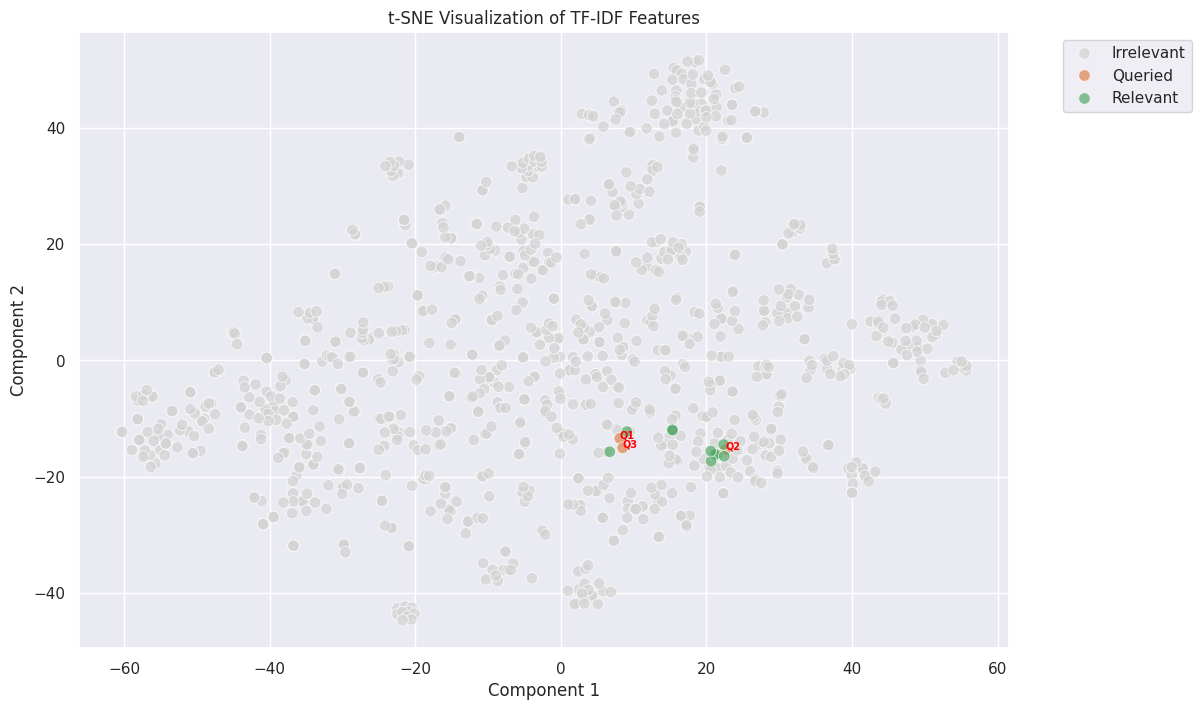

In [138]:
# Scatter
custom_palette = sns.color_palette()[:3]
custom_palette[0] = "lightgray"
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Component 1',
    y='Component 2',
    data=tfidf_df,
    hue=labels,
    palette=custom_palette,
    s=70,
    alpha=0.7
)

# Annotate
queried_points = tfidf_df.iloc[(len(fetched) - limit_output):-limit_output].reset_index()
for i, row in queried_points.iterrows():
    plt.text(row['Component 1'], row['Component 2'], f'Q{i+1}', 
             color='red', fontsize=7, weight='bold')


plt.title('t-SNE Visualization of TF-IDF space')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Queried documents:
* `Q1` - UDP
* `Q2` - IPv6
* `Q3` - Jumbograms

You can see that even though the history of the document should lean towards the `UDP` (it was the last visited document), still `IPv6` is under more profound discussion, and supposedly it matches in-database documents better.

### Term importance

In this section, we delve into term comparison. To make it easier, here is the 

In [299]:
doc = index.to_doc(NameQuery("The MD4 Message-Digest Algorithm"))
fetched = index.query_docs([DocQuery(doc)], skip_visited=True)[0][:3]

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


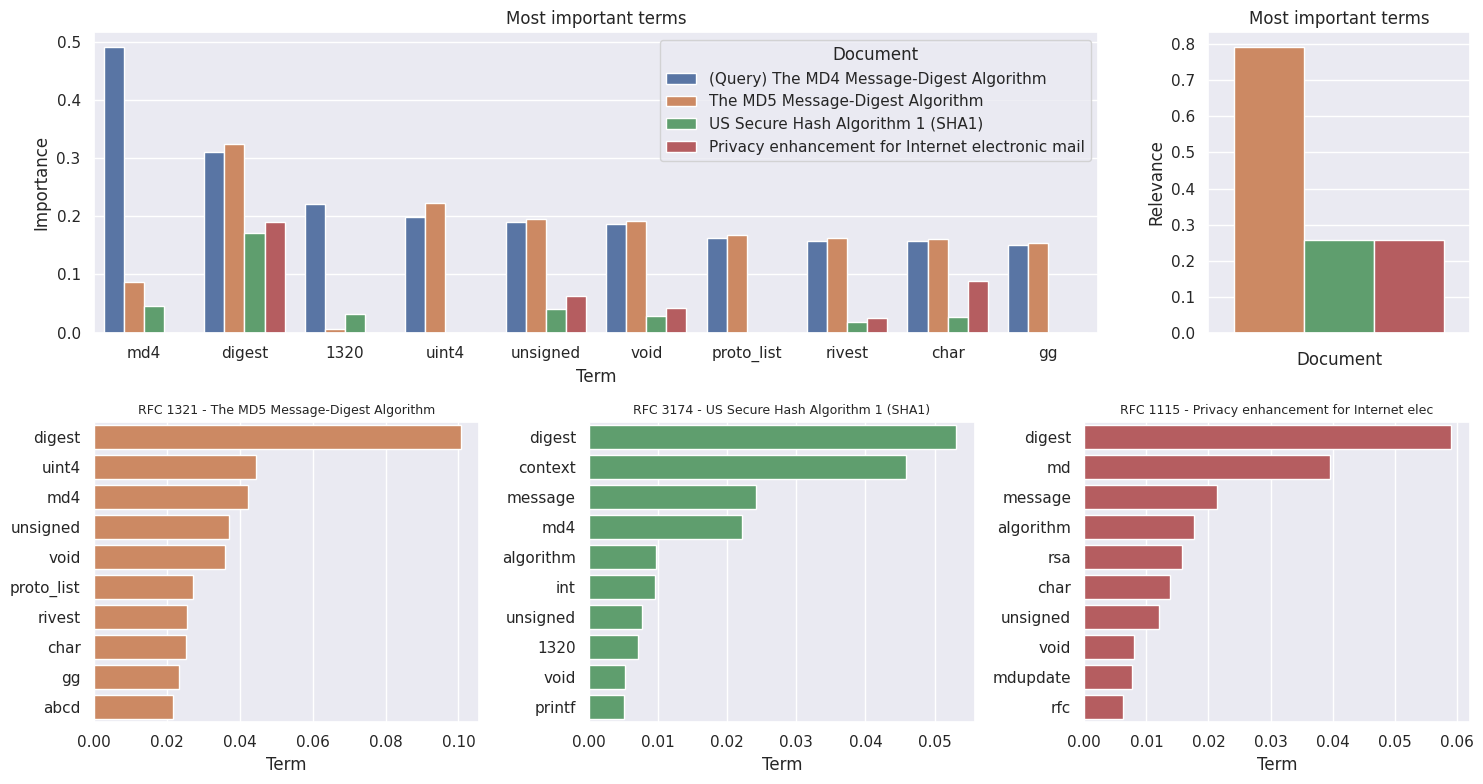

In [301]:
# Get top terms
top_terms = index.tfidf.loc[url].sort_values()[::-1][:limit_output].index

# Fetch the those terms for all docs
dfs = []
for doc_ in [doc] + fetched:
    df = pd.DataFrame(index.tfidf.loc[doc_.url]).loc[top_terms].reset_index()
    df.rename(columns={doc_.url: "value"}, inplace=True)
    name = doc_.name[11:][:48]
    if doc_.url == doc.url:
        name = "(Query) " + name
    df["Document"] = name
    dfs.append(df)

# Combine
new_df = pd.concat(dfs)


# Plot
fig = plt.figure(figsize=(15, 8))

ax = plt.subplot2grid((2, 12), (0, 0), colspan=9)
sns.barplot(new_df, x="index", y="value", hue="Document", ax=ax)
ax.set_title("Most important terms")
ax.set_xlabel("Term")
ax.set_ylabel("Importance")

ax = plt.subplot2grid((2, 12), (0, 9), colspan=3)
sns.barplot(
    hue=[i for i in range(len(fetched))],
    y=[doc_.rank for doc_ in fetched],
    legend=False,
    palette=sns.color_palette()[1:4],
    ax=ax,
)
ax.set_title("Most important terms")
ax.set_xlabel("Document")
ax.set_ylabel("Relevance")

for i, doc_ in enumerate(fetched):
    combined = index.tfidf.loc[doc.url] * index.tfidf.loc[doc_.url]
    combined = combined.sort_values()[::-1][:10]
    ax = plt.subplot2grid((2, 12), (1, i * 4), colspan=4)
    ax.set_title(doc_.name[:48], fontsize=9)
    ax.set_xlabel("Term")
    sns.barplot(combined, ax=ax, orient="h", color=sns.color_palette()[i+1])

plt.tight_layout()

Plots:
* top left: shows TF-IDF values for the most significant terms of the query (`MD4`).
* top right: Ranking of the documents
* bottom: show the direct impact of each term

Observations:
* We can see how close `MD4` and `MD5` are: their term importances are almost identical (for the given terms).
* Other two documents share practically the same similarity to the query, although their top contributer-terms differ noticeably.

## Document / History importance

In [ ]:
limit_output = 10
query = [
    NameQuery("https://en.wikipedia.org/wiki/User_Datagram_Protocol"),
    NameQuery("https://en.wikipedia.org/wiki/IPv6"),
    NameQuery("https://en.wikipedia.org/wiki/Jumbogram"),
]

In [172]:
print(("\n".join(map(str, index.query_docs([DocQuery(doc)], skip_visited=True)[0][:5]))))

0.462 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc2411", name="RFC 2411 - IP Security Document Roadmap", text=...)
0.451 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc2406", name="RFC 2406 - IP Encapsulating Security Payload (ESP)", text=...)
0.416 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc4305", name="RFC 4305 - Cryptographic Algorithm Implementation Requirements for Encapsulating Security Payload (ESP) and Authentication Header (AH)", text=...)
0.368 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc4303", name="RFC 4303 - IP Encapsulating Security Payload (ESP)", text=...)
0.361 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc2407", name="RFC 2407 - The Internet IP Security Domain of Interpretation for ISAKMP", text=...)


In [175]:
doc1 = Document(**asdict(doc))
doc1.url = doc1.url + "__"
doc1.text = doc1.text.lower().replace("ipsec", "").replace("encryption", "").replace("null", "")
print(("\n".join(map(str, index.query_docs([DocQuery(doc1)], skip_visited=True)[0][:5]))))

root(INFO) - Performing lemmatization (tfidf.py:118)
root(INFO) - Transforming TF-IDF (tfidf.py:121)


0.733 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc2410", name="RFC 2410 - The NULL Encryption Algorithm and Its Use With IPsec", text=...)
0.454 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc2406", name="RFC 2406 - IP Encapsulating Security Payload (ESP)", text=...)
0.419 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc2411", name="RFC 2411 - IP Security Document Roadmap", text=...)
0.394 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc4303", name="RFC 4303 - IP Encapsulating Security Payload (ESP)", text=...)
0.384 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc4305", name="RFC 4305 - Cryptographic Algorithm Implementation Requirements for Encapsulating Security Payload (ESP) and Authentication Header (AH)", text=...)


In [163]:

print(("\n".join(map(str, index.query_docs([DocQuery(doc)], skip_visited=True)[0][:5]))))


AttributeError: 'str' object has no attribute 'relace'

### Counterfactual explanation